# Beginners' Guide

## PhysicsNeMo vs. PhysicsNeMo-Sym  

- PhysicsNeMo: 물리 AI 모델을 구축,학습,추론하는 코어 프레임워크. 모델/파이프라인/훈련 유틸 중심.  
- PhysicsNeMo-Sym: PhysicsNeMo의 서브 모듈로, 기호적(symbolic, 수식 기반) 물리 주입 기능(PDE/IBC/domain sampling)을 제공  

##### 학습을 위한 필수 라이브러리 설치

In [1]:
!pip uninstall -y nvidia-physicsnemo fsspec s3fs
!pip install "fsspec==2025.3.0" "s3fs==2025.3.0" "gcsfs==2025.3.0" "jedi>=0.16"
!pip install --no-deps "nvidia-physicsnemo==1.2.0"
!pip install -U hydra-core==1.3.2 omegaconf==2.3.0
#!pip install mlflow
!pip install nvidia-physicsnemo-sym --no-build-isolation
#!pip install --no-deps "nvidia-physicsnemo-sym==2.2.0"

Found existing installation: nvidia-physicsnemo 1.2.0
Uninstalling nvidia-physicsnemo-1.2.0:
  Successfully uninstalled nvidia-physicsnemo-1.2.0
Found existing installation: fsspec 2025.3.0
Uninstalling fsspec-2025.3.0:
  Successfully uninstalled fsspec-2025.3.0
Found existing installation: s3fs 2025.3.0
Uninstalling s3fs-2025.3.0:
  Successfully uninstalled s3fs-2025.3.0
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached s3fs-2025.3.0-py3-none-any.whl.metadata (1.9 kB)
Using cached fsspec-2025.3.0-py3-none-any.whl (193 kB)
Using cached s3fs-2025.3.0-py3-none-any.whl (30 kB)
  Using cached nvidia_physicsnemo-1.2.0-py3-none-any.whl.metadata (27 kB)
Using cached nvidia_physicsnemo-1.2.0-py3-none-any.whl (805 kB)


##### 튜토리얼용 configuration file 및 data를 포함하는 디렉토리 다운로드

In [2]:
!git clone https://github.com/heechangkim/physicsnemo_FNO_tutorial.git

fatal: destination path 'physicsnemo_FNO_tutorial' already exists and is not an empty directory.


##### Fix the random seed to get consistent results

In [1]:
##### Seed 고정
import os
import random
import numpy as np
import torch
seed_ = 1234

def set_seed(seed=1234, deterministic=True):
    os.environ["PYTHONHASHSEED"] = str(seed)   # 파이썬 해시 시드
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    if deterministic:
        # CUDA 연산 결정적 모드
        torch.use_deterministic_algorithms(True, warn_only=True)
        # cuDNN 관련
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        # cublas 결정성
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"  # 또는 ":4096:8"

set_seed(1234)

## Solving Darcy Flow with Fourier Neural Operator (FNO) using PhysicsNemo & PhysicsNemo-Sym

## Problem Description  
Solve Darcy flow
$-\nabla \cdot (k(x)\nabla u(x)) = f(x), \quad x\in D$  
- $u(x)$: the pressure field, $k(x)$: the permeability field, $f(x)$: source term.  
- Domain $D = \{x,y \in (0,1) \}$ with zero boundary condition: $u(x) = 0, x \in \partial D$.  
- Discretization: $K, U \in \mathbb{R}^{N\times N}$ on an $N \times N$ grid.
- Goal: learn a surrogate mapping $\mathcal{G}: K \rightarrow U$.  


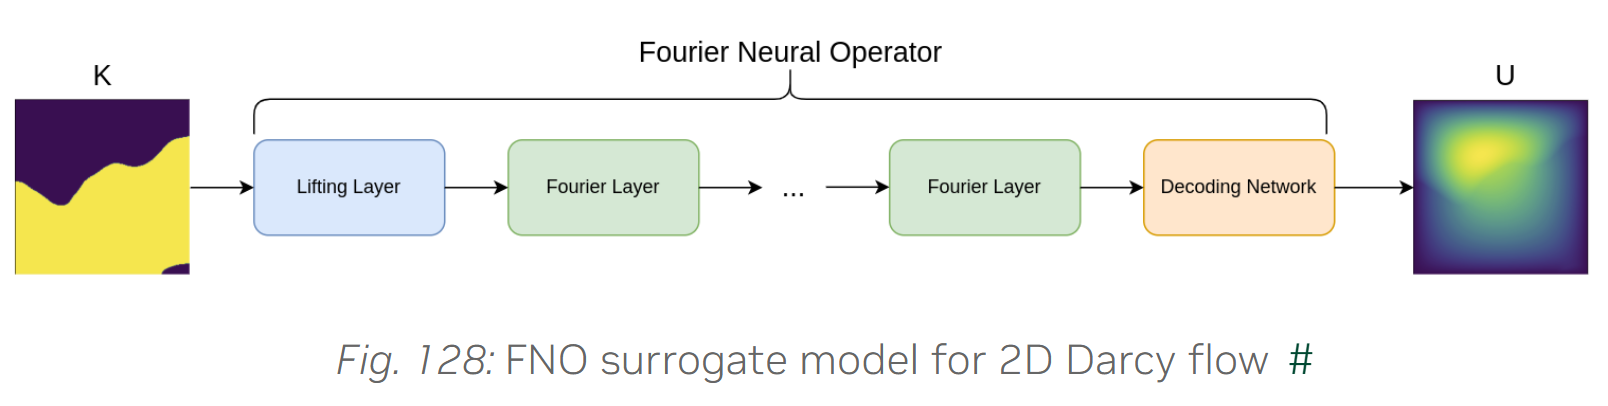

### PhysicsNeMo-Sym tutorial, Darcy Flow  

<style>
/* 이 이미지(alt 텍스트가 config-flow)만 60% 폭 + 가운데 정렬 */
img[alt="workflow_physicsnemo-sym"] {
  width:50%; height:auto; display:block; margin:0 auto; border:0; box-shadow:none;
}
</style>

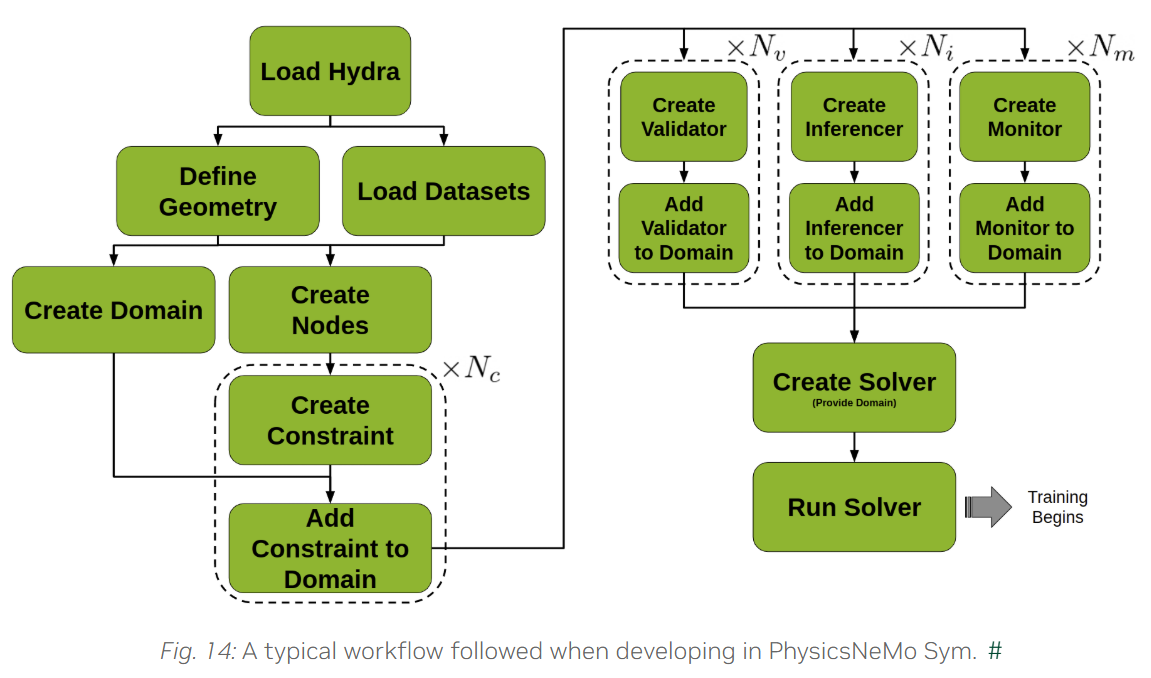

PhysicsNeMo-Sym 은 위의 과정을 거쳐 학습 workflow를 생성함.

### 1. Configuration

<style>
/* 이 이미지(alt 텍스트가 config-flow)만 60% 폭 + 가운데 정렬 */
img[alt="config-flow"] {
  width:50%; height:auto; display:block; margin:0 auto; border:0; box-shadow:none;
}
</style>

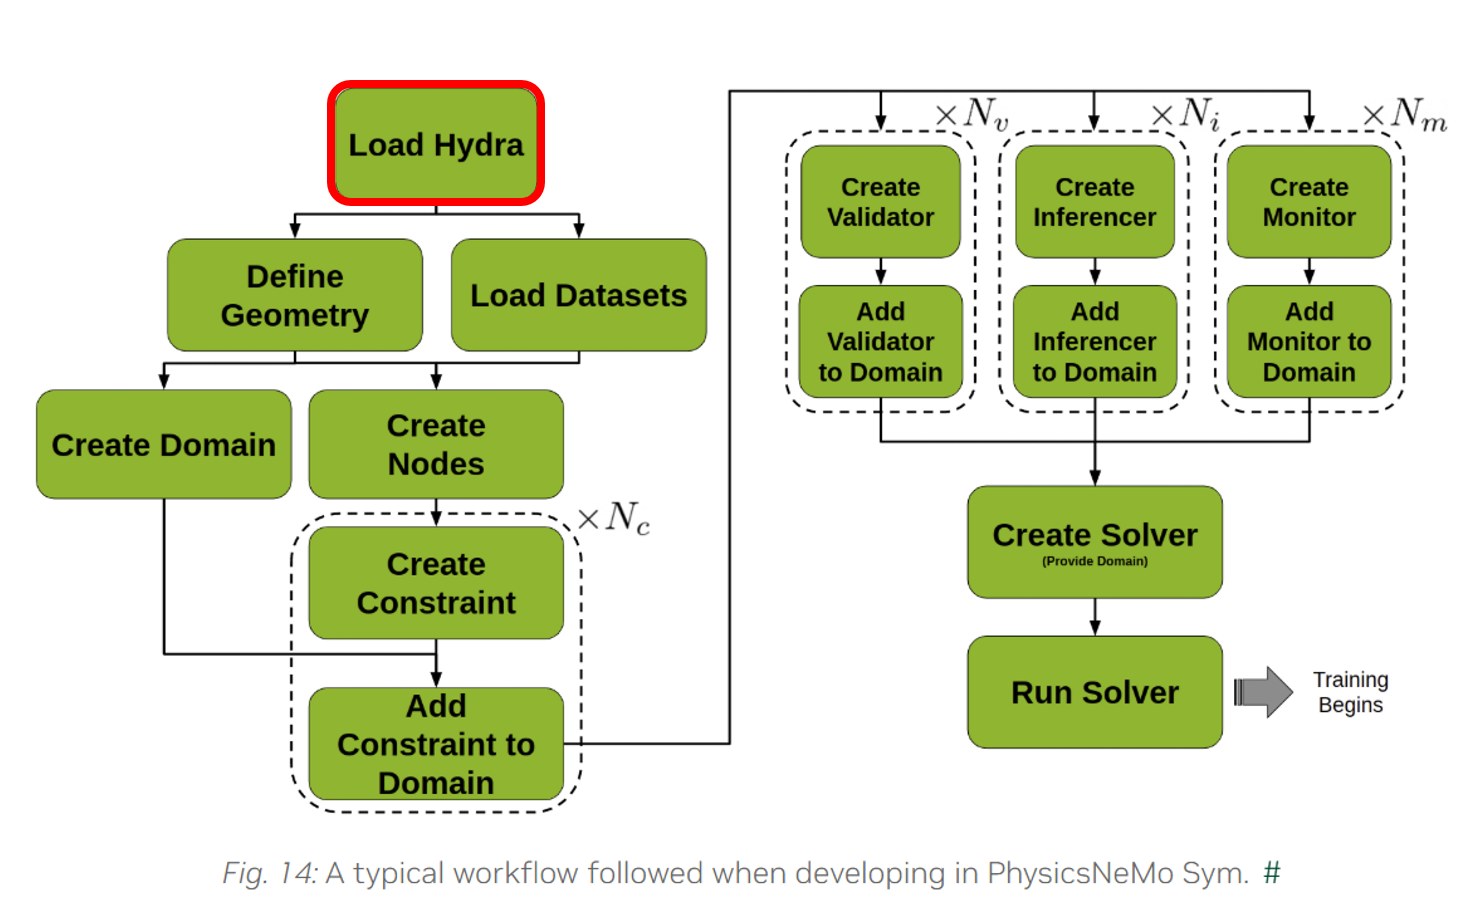

##### Load Configuration

In [2]:

## ====================================================
## Configuration 을 불러오기 위한 함수 import
## ====================================================
from hydra.utils import to_absolute_path
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf

## ====================================================
## Load configuration
## ====================================================
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()
initialize(version_base="1.3", config_path="conf")
config_name = "config_FNO_sym"
cfg = compose(config_name=config_name)
cfg.network_dir='outputs_sym'

##### Config 로드 확인: 설정 파일 출력

In [3]:
want = ["arch", "training","optimizer"]
slim = OmegaConf.masked_copy(cfg, want)
print(OmegaConf.to_yaml(slim))

training:
  max_steps: 2000
  grad_agg_freq: 1
  rec_results_freq: 1000
  rec_validation_freq: ${training.rec_results_freq}
  rec_inference_freq: ${training.rec_results_freq}
  rec_monitor_freq: ${training.rec_results_freq}
  rec_constraint_freq: ${training.rec_results_freq}
  save_network_freq: 1000
  print_stats_freq: 100
  summary_freq: 1000
  grad_clip_max_norm: 0.5
  monitor_grad_clip: true
  ntk:
    use_ntk: false
    save_name: null
    run_freq: 1000
arch:
  decoder:
    arch_type: conv_fully_connected
    input_keys:
    - z
    - 32
    output_keys: sol
    detach_keys: ???
    scaling: null
    layer_size: 32
    nr_layers: 1
    skip_connections: false
    activation_fn: silu
    adaptive_activations: false
    weight_norm: true
  fno:
    arch_type: fno
    input_keys: coeff
    output_keys: ???
    detach_keys: ???
    scaling: null
    dimension: 2
    nr_fno_layers: 4
    fno_modes: 12
    padding: 9
    padding_type: constant
    activation_fn: gelu
    coord_features

### 2. Load Datasets

<style>
/* 이 이미지(alt 텍스트가 config-flow)만 60% 폭 + 가운데 정렬 */
img[alt="image"] {
  width:50%; height:auto; display:block; margin:0 auto; border:0; box-shadow:none;
}
</style>

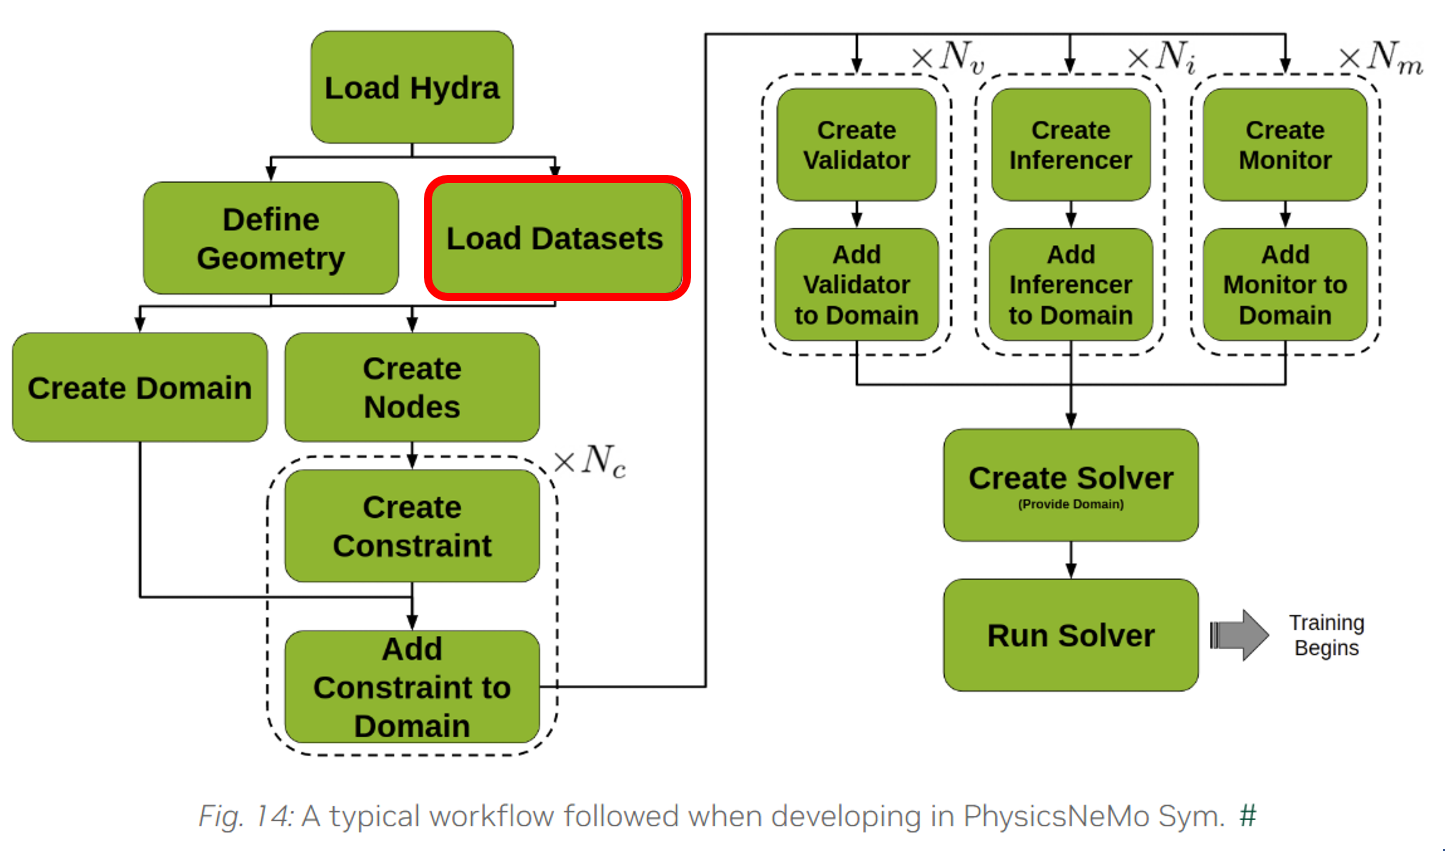

##### Define function to load dataset

In [4]:
## ====================================================
## 데이터 경로와 입출력 키를 이용해 데이터 불러오기
## ====================================================
import h5py

def load_FNO_dataset(path, input_keys, output_keys, n_examples=None):
    "Loads a FNO dataset"

    if not path.endswith(".hdf5"):
        raise Exception(
            ".hdf5 file required: please use utilities.preprocess_FNO_mat to convert .mat file"
        )

    # load data
    path = to_absolute_path(path)
    data = h5py.File(path, "r")
    _ks = [k for k in data.keys() if not k.startswith("__")]
    print(f"loaded: {path}\navaliable keys: {_ks}")

    # parse data
    invar, outvar = dict(), dict()
    for d, keys in [(invar, input_keys), (outvar, output_keys)]:
        for k in keys:
            # get data
            x = data[k]  # N, C, H, W

            # cut examples out
            if n_examples is not None:
                x = x[:n_examples]

            # print out normalisation values
            print(f"selected key: {k}, mean: {x.mean():.5e}, std: {x.std():.5e}")

            d[k] = x
    del data

    return (invar, outvar)

##### Load dataset

In [5]:
from physicsnemo.sym.key import Key
from physicsnemo.sym.hydra import instantiate_arch
from physicsnemo.sym.dataset import DictGridDataset

###### input key 로 "coeff", output key로 "sol" 사용 ######
input_keys = [Key("coeff", scale=(7.48360e00, 4.49996e00))]
output_keys = [Key("sol", scale=(5.74634e-03, 3.88433e-03))]

##### load Training dataset
invar_train, outvar_train = load_FNO_dataset(
    "data/piececonst_r61_N1024_smooth1.hdf5",
    [k.name for k in input_keys],
    [k.name for k in output_keys],
    n_examples=1000,
)

##### load Test dataset
invar_test, outvar_test = load_FNO_dataset(
    "data/piececonst_r61_N1024_smooth2.hdf5",
    [k.name for k in input_keys],
    [k.name for k in output_keys],
    n_examples=100,
)

train_dataset = DictGridDataset(invar_train, outvar_train)
test_dataset = DictGridDataset(invar_test, outvar_test)

loaded: /home/hkim/Codes/physicsnemo_FNO_tutorial/Darcy_FNO/data/piececonst_r61_N1024_smooth1.hdf5
avaliable keys: ['coeff', 'sol']
selected key: coeff, mean: 7.48309e+00, std: 4.49997e+00
selected key: sol, mean: 5.60443e-03, std: 3.93984e-03
loaded: /home/hkim/Codes/physicsnemo_FNO_tutorial/Darcy_FNO/data/piececonst_r61_N1024_smooth2.hdf5
avaliable keys: ['coeff', 'sol']
selected key: coeff, mean: 7.60870e+00, std: 4.49869e+00
selected key: sol, mean: 5.48695e-03, std: 3.86348e-03


In [6]:
## ====================================================
## Check data
## ====================================================
print(f"Input of train dataset: {train_dataset.invar['coeff'].shape}")
print(f"Output of train dataset: {train_dataset.outvar['sol'].shape}")
print(f"Input of test dataset: {test_dataset.invar['coeff'].shape}")
print(f"Output of test dataset: {test_dataset.outvar['sol'].shape}")

Input of train dataset: torch.Size([1000, 1, 61, 61])
Output of train dataset: torch.Size([1000, 1, 61, 61])
Input of test dataset: torch.Size([100, 1, 61, 61])
Output of test dataset: torch.Size([100, 1, 61, 61])


##### Plot data

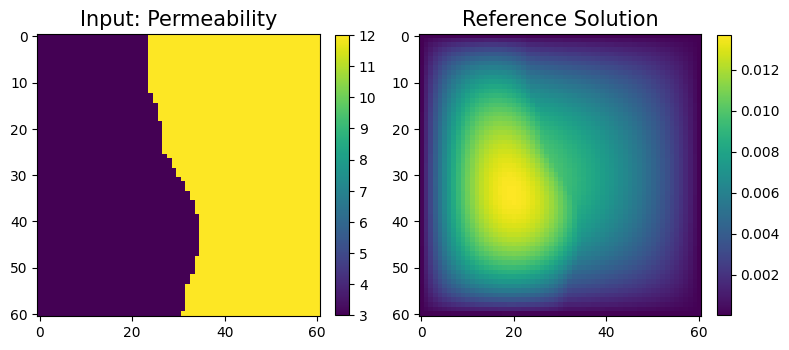

In [7]:
## ====================================================
## Load library for data visualization
## ====================================================
import matplotlib.pyplot as plt

## ====================================================
## Define visualization function
## ====================================================
def plot_func(*args, **kwargs):
    figure_num = len(args)
    plt.figure(figsize=(figure_num*4,4))
    for i, (data, title) in enumerate(zip(args, kwargs.get('titles', []))):
        plt.subplot(1, len(args), i+1)
        plt.imshow(data)
        plt.colorbar(fraction=0.045)
        if title:
            plt.title(title, fontsize=15)
    plt.tight_layout()
    plt.show()


plot_func(invar_train['coeff'][0,0], outvar_train['sol'][0,0], titles=['Input: Permeability', 'Reference Solution'])

### 3. Create Nodes

<style>
/* 이 이미지(alt 텍스트가 config-flow)만 60% 폭 + 가운데 정렬 */
img[alt="Nodes"] {
  width:50%; height:auto; display:block; margin:0 auto; border:0; box-shadow:none;
}
</style>

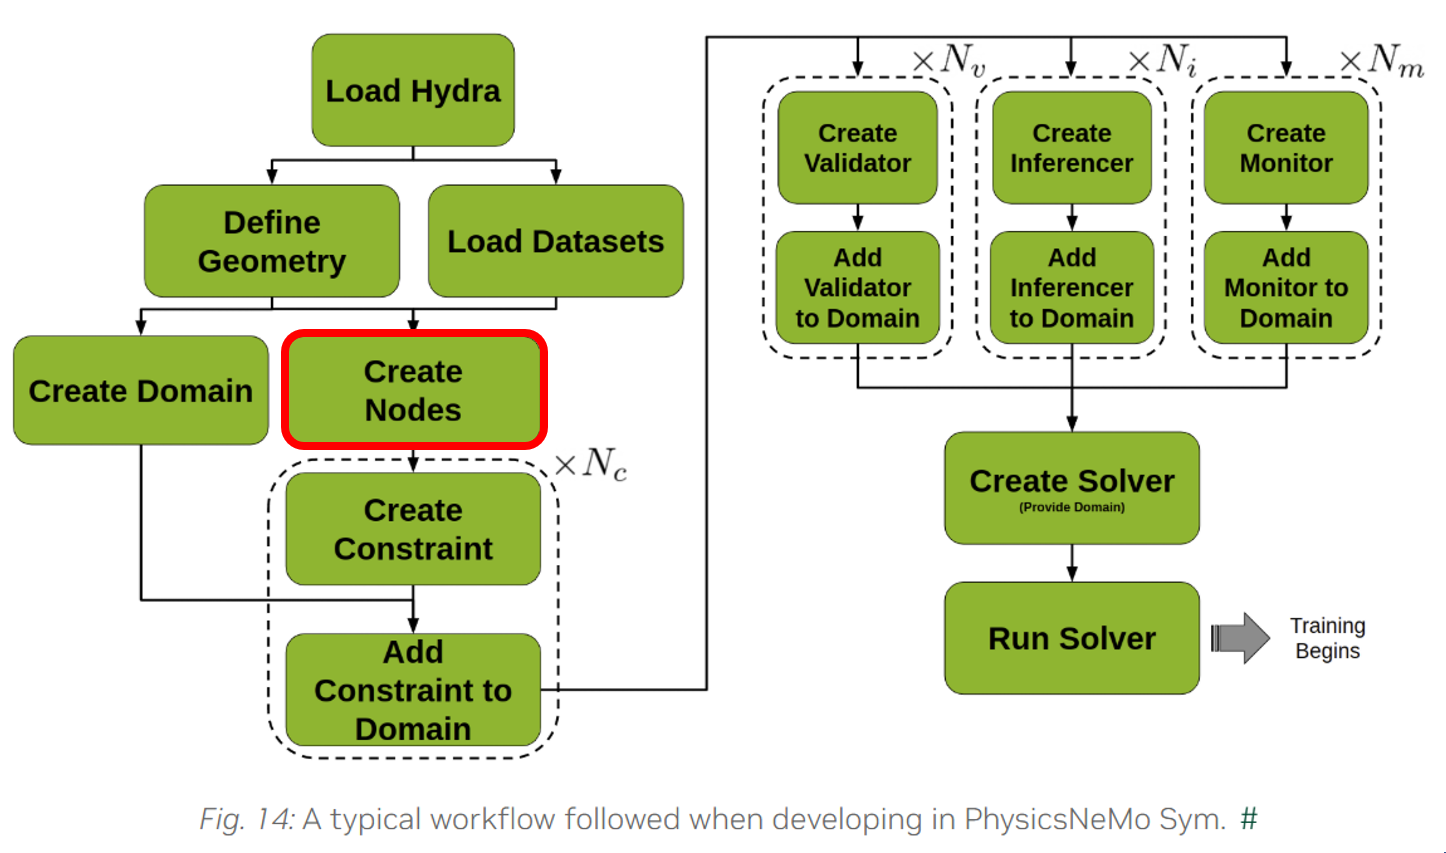

##### Declare Fourier Neural Operator Model

In [8]:
## ====================================================
## Decoder network
## ====================================================
decoder_net = instantiate_arch(
    cfg=cfg.arch.decoder,
    output_keys=output_keys,
)
## ====================================================
## FNO model
## ====================================================
fno = instantiate_arch(
    cfg=cfg.arch.fno,
    input_keys=input_keys,
    decoder_net=decoder_net,
)
## ====================================================
## Create Nodes using the model
## ====================================================
nodes = [fno.make_node("fno")]

/home/hkim/anaconda3/envs/hkim_physicsnemo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 4. Create Domain

<style>
/* 이 이미지(alt 텍스트가 config-flow)만 60% 폭 + 가운데 정렬 */
img[alt="Domain"] {
  width:50%; height:auto; display:block; margin:0 auto; border:0; box-shadow:none;
}
</style>

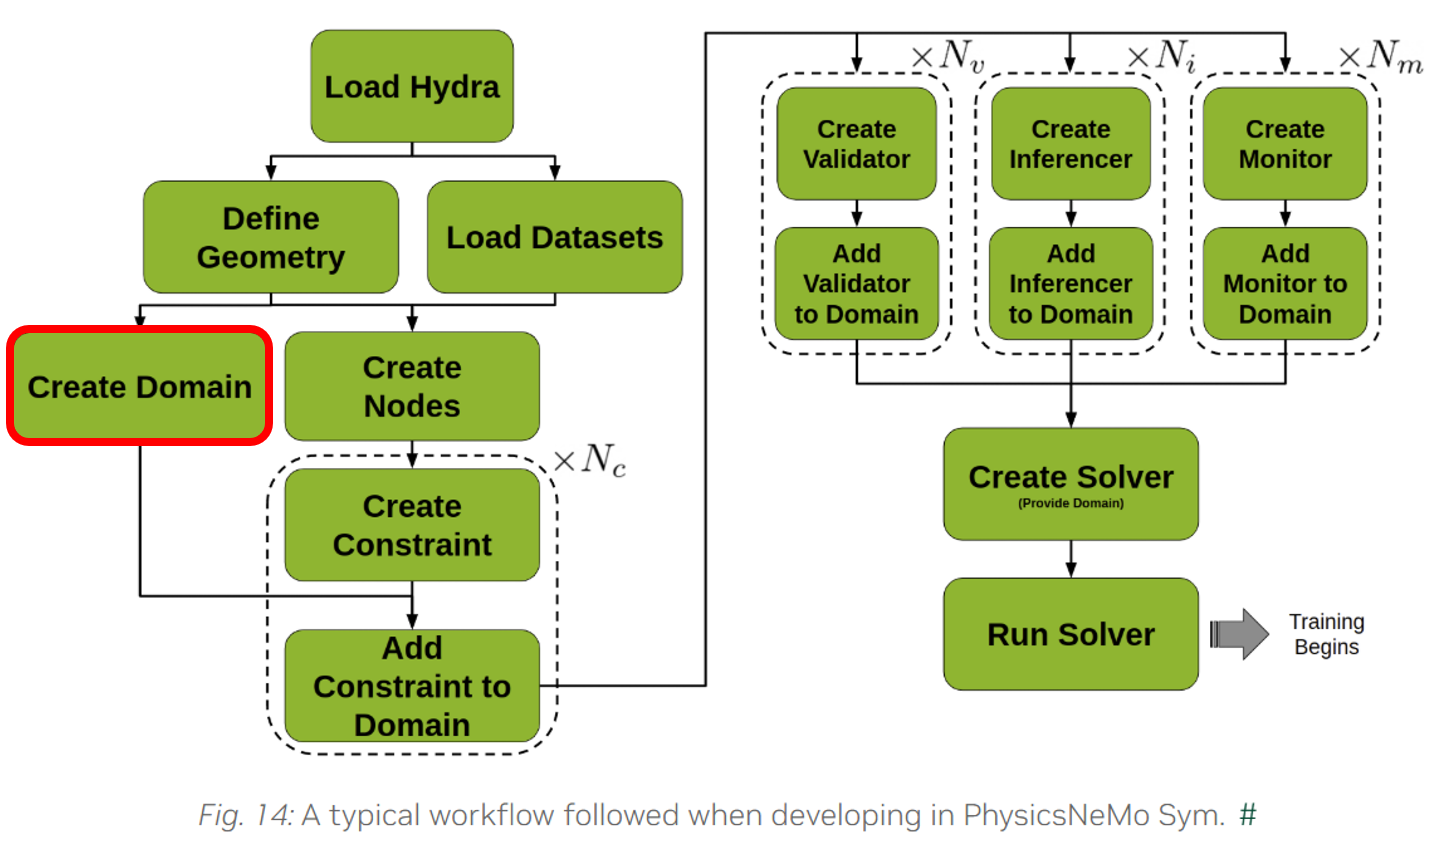

##### Declare Domain

In [9]:
from physicsnemo.sym.domain import Domain

domain = Domain()

### 5. Create Constraints and Add Constraint to Domain

<style>
/* 이 이미지(alt 텍스트가 config-flow)만 60% 폭 + 가운데 정렬 */
img[alt="Constraint"] {
  width:50%; height:auto; display:block; margin:0 auto; border:0; box-shadow:none;
}
</style>

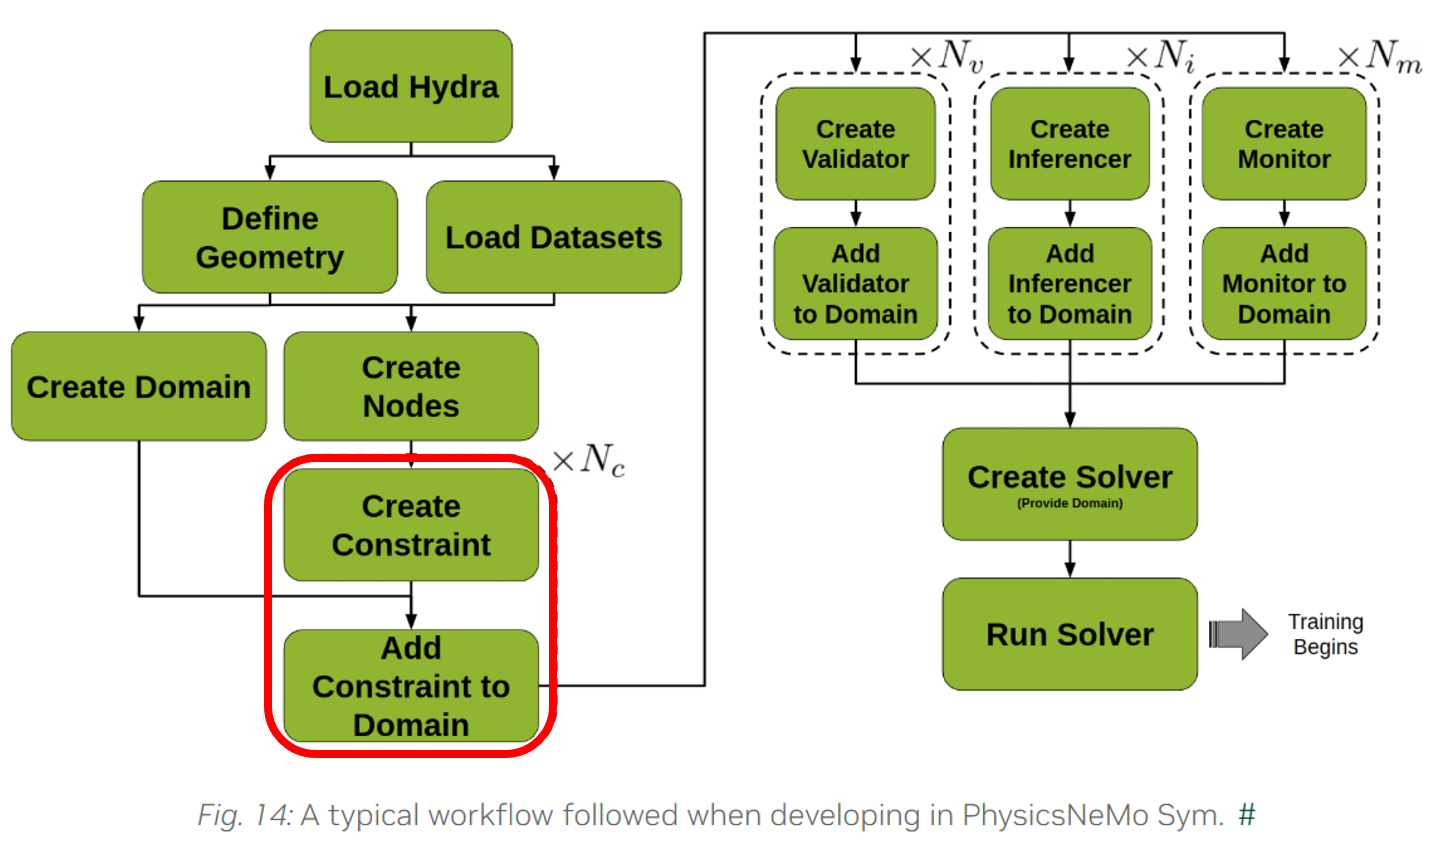

##### Declare Constraints and add it to domain

In [10]:
from physicsnemo.sym.domain.constraint import SupervisedGridConstraint

## ====================================================
## Create Constraint. Here, we create SupervisedGridConstraint
## ====================================================
## 즉, reference solution을 가지고 지도학습.
supervised = SupervisedGridConstraint(
    nodes=nodes,
    dataset=train_dataset,
    batch_size=cfg.batch_size.grid,
)

## ====================================================
## Add Constraint to Domain
## ====================================================
domain.add_constraint(supervised, "supervised")

### 5. Create Validator and Add Validator to Domain

<style>
/* 이 이미지(alt 텍스트가 config-flow)만 60% 폭 + 가운데 정렬 */
img[alt="Validator"] {
  width:50%; height:auto; display:block; margin:0 auto; border:0; box-shadow:none;
}
</style>

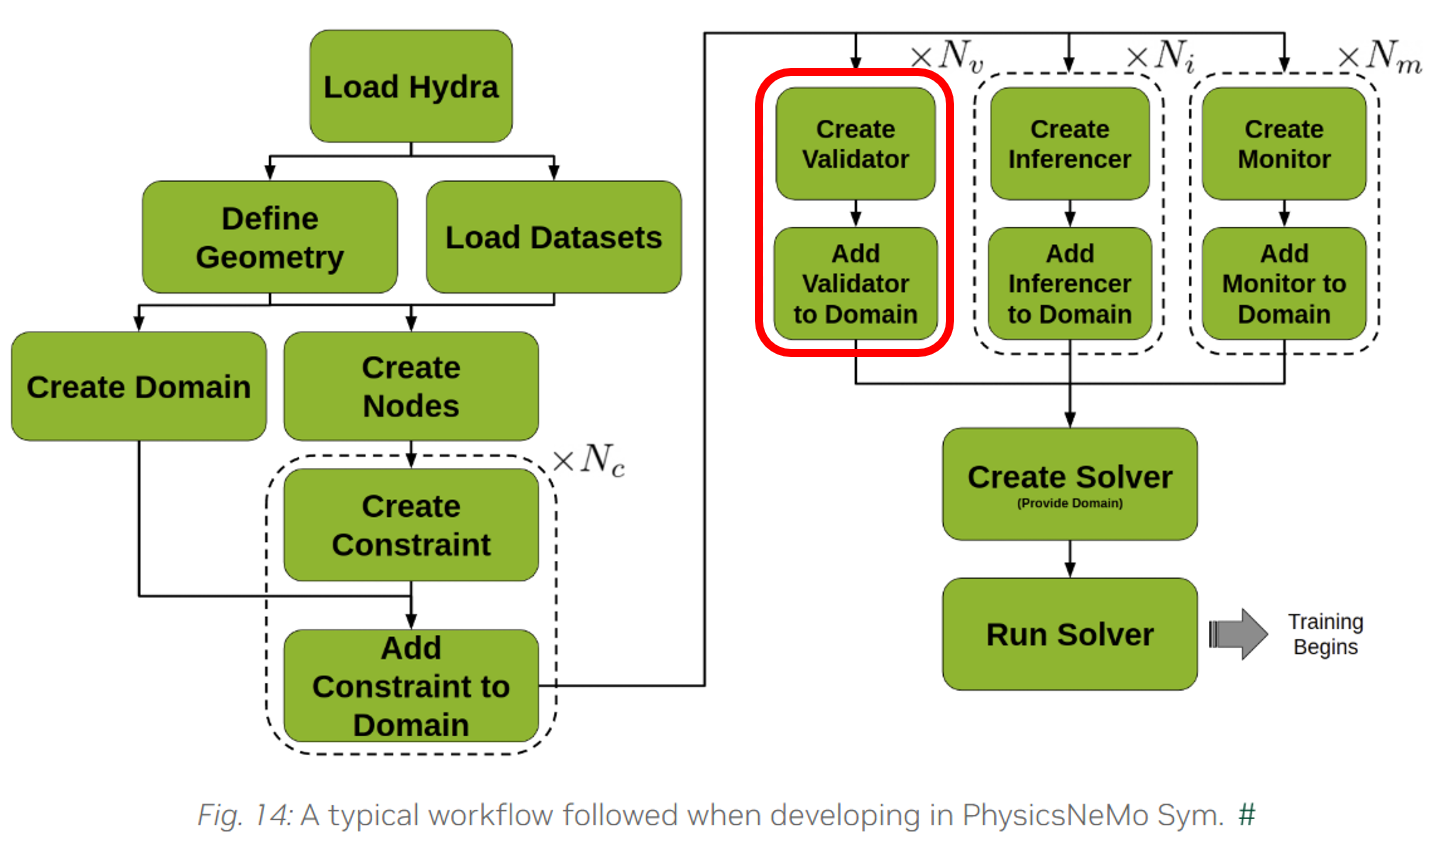

##### Declare Validator and add it to Domain

In [11]:
from physicsnemo.sym.domain.validator import GridValidator
from physicsnemo.sym.utils.io.plotter import GridValidatorPlotter

## ====================================================
## Create Validator
## ====================================================
val = GridValidator(
    nodes,
    dataset=test_dataset,
    batch_size=cfg.batch_size.validation,
    plotter=GridValidatorPlotter(n_examples=5),
)

## ====================================================
## Add Validator to Domain
## ====================================================
domain.add_validator(val, "test")

### 6. Create Solver and Run Solver

<style>
/* 이 이미지(alt 텍스트가 config-flow)만 60% 폭 + 가운데 정렬 */
img[alt="Solver"] {
  width:50%; height:auto; display:block; margin:0 auto; border:0; box-shadow:none;
}
</style>

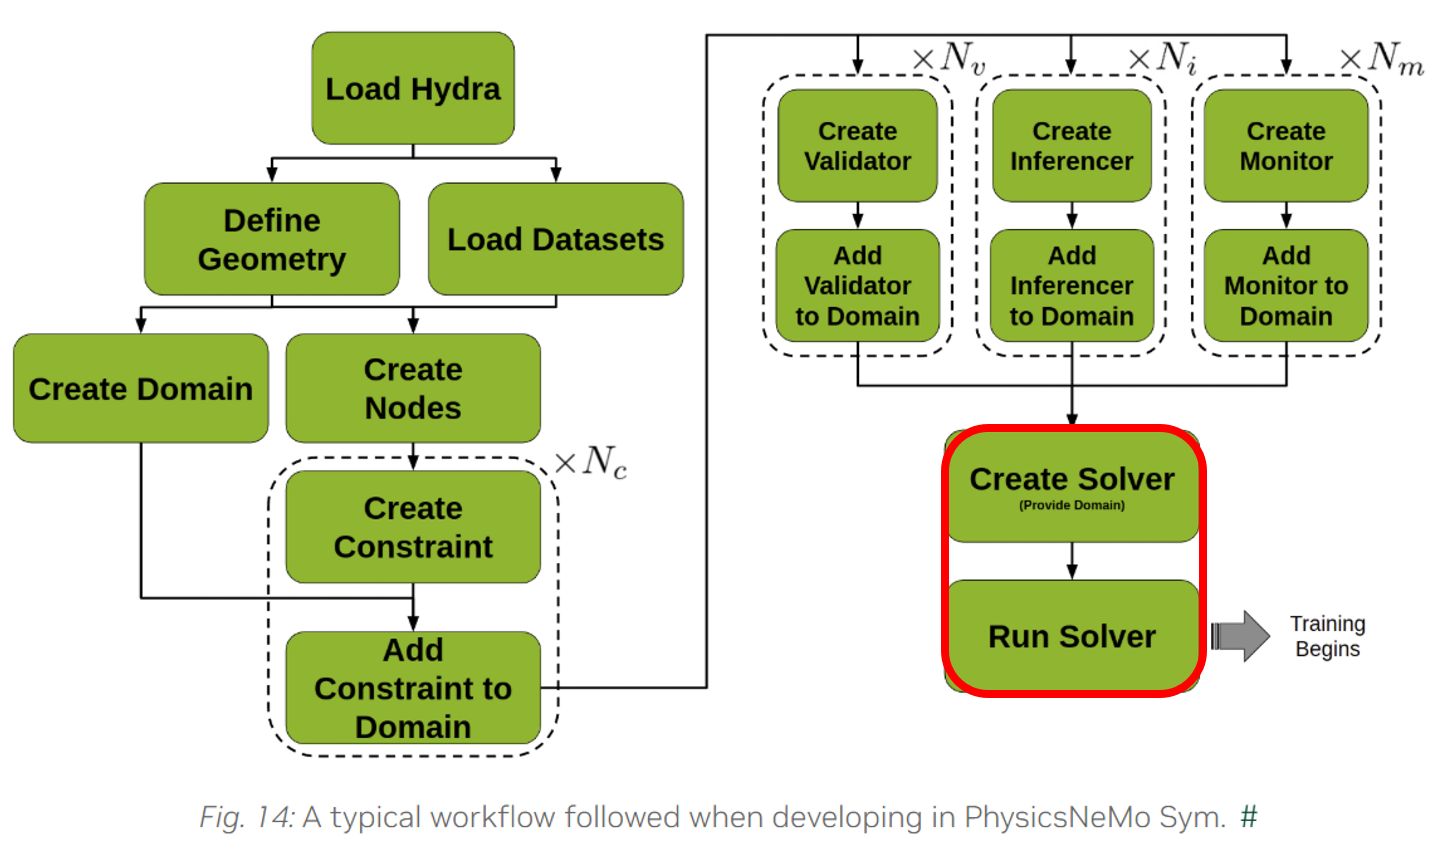

##### logger를 선언 (Jupyter Notebook에서 로그를 확인하기 위해 추가)

In [12]:
import logging, re, pathlib
from physicsnemo.sym.solver import Solver

###### Get logger
logger = logging.getLogger()

## ====================================================
## make train.log to plot loss graph later...
## ====================================================
logfile = pathlib.Path("train.log")
fh = logging.FileHandler(logfile, mode="w")

##### log가 어느 레벨까지 출력할 것인지 set
logger.setLevel(logging.INFO)
stream_handler = logging.StreamHandler()
logger.addHandler(stream_handler)
logger.addHandler(fh)

##### Create Solver and Run Solver

In [13]:
## ====================================================
## Config 파일과 Domain을 이용해 Solver 생성
## ====================================================
slv = Solver(cfg, domain)

# start solver
slv.solve()

Installed PyTorch version 2.9.0+cu128 is not TorchScript supported in PhysicsNeMo. Version 2.1.0a0+4136153 is officially supported.
/home/hkim/anaconda3/envs/hkim_physicsnemo/lib/python3.12/site-packages/physicsnemo/sym/amp.py:219: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  super().__init__(*args, **kwargs)
attempting to restore from: /home/hkim/Codes/physicsnemo_FNO_tutorial/Darcy_FNO/outputs_sym
optimizer checkpoint not found
model fno.0.pth not found
[step:          0] record constraint batch time:  3.343e-02s
[step:          0] record validators time:  1.880e+00s
[step:          0] saved checkpoint to /home/hkim/Codes/physicsnemo_FNO_tutorial/Darcy_FNO/outputs_sym
[step:          0] loss:  1.867e+00
Attempting cuda graph building, this may take a bit...
[step:        100] loss:  2.412e-02, time/iteration:  1.132e+02 ms
[step:        200] loss:  7.984e-03, time/iteration:  7.988e+00 ms
[step:      

#### 학습 종료 후, loss curve check

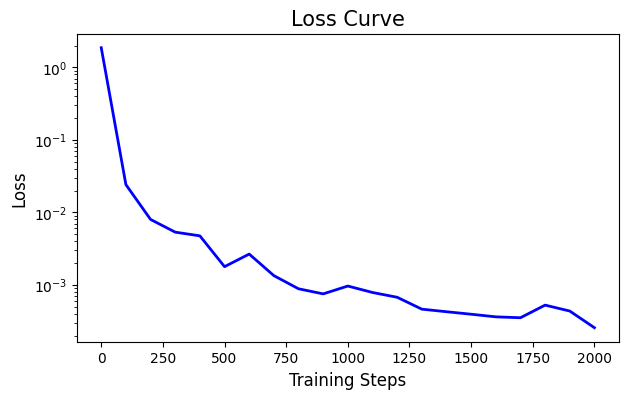

In [14]:
##### logfile 에서 loss 값 읽어오기
text = logfile.read_text()
loss_pairs = [(int(s), float(v)) for s, v in re.findall(r"\[step:\s*(\d+)\]\s+loss:\s+([0-9.eE+-]+)", text)]

##### loss 그래프 그리기
plt.figure(figsize=(7,4))
plt.plot([t for t, v in loss_pairs], [v for t, v in loss_pairs], label='Training Loss',lw=2,color='blue')
plt.semilogy()
plt.title('Loss Curve', fontsize=15)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Training Steps', fontsize=12)
plt.show()

##### 학습 이후 모델 테스트 성능 평가

In [15]:
import torch
import numpy as np
##### Test dataset으로 평가
invar_test_ = {'coeff' : torch.tensor(invar_test['coeff']).cuda()}

##### Evaluate the model
fno.eval()
with torch.no_grad():
    out = fno.forward(invar_test_)['sol']

##### Plot the graph

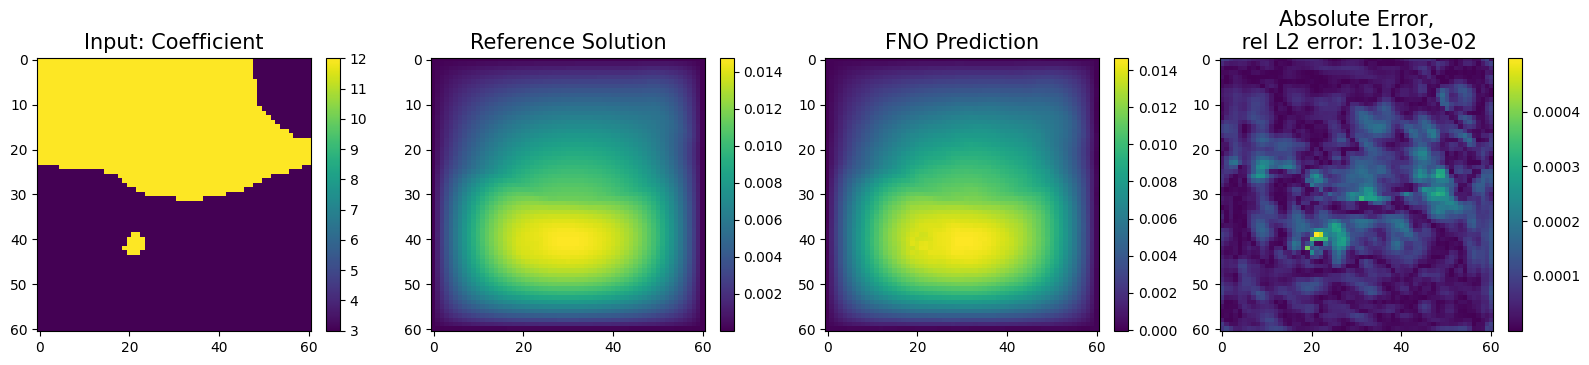

In [16]:
idx = 0

pred = out.detach().cpu().numpy()[idx,0]    ## Prediction
ref = outvar_test['sol'][idx,0]             ## Reference solution
input_ = invar_test['coeff'][idx,0]         ## Input coefficient

rel_l2_err = np.linalg.norm(ref - pred) / np.linalg.norm(ref)

plot_func(input_, ref, pred,np.abs(ref-pred),
          titles=['Input: Coefficient', 'Reference Solution', 'FNO Prediction', f'Absolute Error,\n rel L2 error: {rel_l2_err:.3e}'])

----
### PhysicsNeMo tutorial, Darcy Flow   

##### Load Configuration

In [17]:
## ====================================================
## Load configuration
## ====================================================
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()
initialize(version_base="1.3", config_path="conf")
config_name = "config_FNO"
cfg = compose(config_name=config_name)

##### Config 로드 확인: 설정 파일 출력

In [18]:
want = ["arch", "training","optimizer"]
slim = OmegaConf.masked_copy(cfg, want)
print(OmegaConf.to_yaml(slim))

arch:
  decoder:
    out_features: 1
    layers: 1
    layer_size: 32
  fno:
    in_channels: 1
    dimension: 2
    latent_channels: 32
    fno_layers: 4
    fno_modes: 12
    padding: 9
training:
  resolution: 61
  batch_size: 64
  rec_results_freq: 8
  max_pseudo_epochs: 256
  pseudo_epoch_sample_size: 2048



### 2. Load Datasets  


##### Define function to load dataset

In [19]:
import h5py
import numpy as np

def load_FNO_dataset_raw(path, n_examples=None):
    if not path.endswith(".hdf5"):
        raise Exception(
            ".hdf5 file required: please use utilities.preprocess_FNO_mat to convert .mat file"
        )
    # load ata
    with h5py.File(path, 'r') as f:
        inputs = f['coeff'][:n_examples]
        outputs = f['sol'][:n_examples]
    return inputs, outputs

##### Load dataset

In [20]:
coeff_mean, coeff_std = 7.48360e00, 4.49996e00
sol_mean, sol_std = 5.74634e-03, 3.88433e-03

##### Load train dataset
train_input, train_output = load_FNO_dataset_raw('data/piececonst_r61_N1024_smooth1.hdf5',n_examples=1000)

##### Load test dataset
test_input, test_output = load_FNO_dataset_raw('data/piececonst_r61_N1024_smooth2.hdf5',n_examples=200)
##### split test dataset into validation and test set
test_input, vali_input = test_input[:100], test_input[100:200]
test_output, vali_output = test_output[:100], test_output[100:200]

##### Normalization
train_input = torch.Tensor((train_input - coeff_mean)/coeff_std)
vali_input = torch.Tensor((vali_input - coeff_mean)/coeff_std)
test_input = torch.Tensor((test_input - coeff_mean)/coeff_std)
train_output = torch.Tensor(train_output)
vali_output = torch.Tensor(vali_output)
test_output = torch.Tensor(test_output)

##### Make data loader
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_input, train_output), batch_size = cfg.training.batch_size,shuffle=True)
vali_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(vali_input, vali_output),batch_size = 50,shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_input, test_output),batch_size = 50,shuffle=False)

##### Check and plot data

Input of train dataset: torch.Size([1000, 1, 61, 61])
Output of train dataset: torch.Size([1000, 1, 61, 61])
Input of test dataset: torch.Size([100, 1, 61, 61])
Output of test dataset: torch.Size([100, 1, 61, 61])


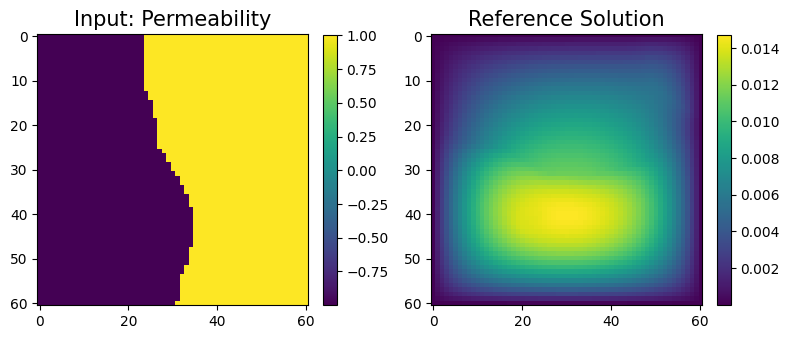

In [21]:
## ====================================================
## Check data
## ====================================================
print(f"Input of train dataset: {train_input.shape}")
print(f"Output of train dataset: {train_output.shape}")
print(f"Input of test dataset: {test_input.shape}")
print(f"Output of test dataset: {test_output.shape}")

plot_func(train_input[0,0], test_output[0,0], titles=['Input: Permeability', 'Reference Solution'])

##### Declare Fourier Neural Operator Model

In [22]:
import torch
from physicsnemo.models.fno import FNO

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = FNO(
        in_channels=cfg.arch.fno.in_channels,
        out_channels=cfg.arch.decoder.out_features,
        decoder_layers=cfg.arch.decoder.layers,
        decoder_layer_size=cfg.arch.decoder.layer_size,
        dimension=cfg.arch.fno.dimension,
        latent_channels=cfg.arch.fno.latent_channels,
        num_fno_layers=cfg.arch.fno.fno_layers,
        num_fno_modes=cfg.arch.fno.fno_modes,
        padding=cfg.arch.fno.padding,
    ).to(device)

##### Declare loss function and optimizer

In [23]:
from torch.nn import MSELoss
from torch.optim import Adam, lr_scheduler
#### L2 loss function
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)
## ====================================================
## We use MSE loss to train the model
## ====================================================
# loss_fun = MSELoss(reduction="mean")
loss_fun = LpLoss()
## ====================================================
## We use Adam optimizer and learning rate scheduler
## ====================================================
optimizer = Adam(model.parameters(), lr=cfg.scheduler.initial_lr)
scheduler = lr_scheduler.LambdaLR(
    optimizer, lr_lambda=lambda step: cfg.scheduler.decay_rate**step
)

##### Start Training

In [24]:
import time
from timeit import default_timer

epochs = 30

start = time.time()
training_loss_list = []
validation_loss_list = []
for epoch in range(epochs):
  t1 = default_timer()

  ##### Training Model
  model.train()
  for x,y in train_loader:
    x,y = x.to(device), y.to(device)    ## Move data to device
    optimizer.zero_grad()

    out = model(x).reshape(y.shape)     ## Prediction
    out = out*sol_std + sol_mean        ## Denormalization
    loss = loss_fun(out, y)             ## Compute loss
    loss.backward()                     ## Backpropagation
    optimizer.step()                    ## Update weights
    training_loss_list.append(loss.item())
  scheduler.step()                      ## Update learning rate


  ##### Evaluate Model
  model.eval()                          ## Set model to evaluation mode
  vali_mse = 0
  with torch.no_grad():
    nvali=0
    for x,y in vali_loader:
      x,y = x.to(device), y.to(device)  ## Move data to device
      out = model(x).reshape(y.shape)   ## Prediction
      out = out*sol_std + sol_mean      ## Denormalization
      vali_loss = loss_fun(out, y)           ## Compute loss
      vali_mse += vali_loss.item()           ## Accumulate validation loss
      nvali+=1
  vali_mse /= nvali
  loss = loss.item()

  validation_loss_list.append(vali_mse)
  t2 = default_timer()
  print("Epoch: %d, time: %.3f, Train Loss: %.3e, Vali Loss: %.3e" % (epoch, t2-t1, loss, vali_mse ))


Epoch: 0, time: 0.530, Train Loss: 5.099e-01, Vali Loss: 4.896e-01
Epoch: 1, time: 0.273, Train Loss: 2.529e-01, Vali Loss: 2.392e-01
Epoch: 2, time: 0.269, Train Loss: 1.292e-01, Vali Loss: 1.318e-01
Epoch: 3, time: 0.270, Train Loss: 9.741e-02, Vali Loss: 1.030e-01
Epoch: 4, time: 0.264, Train Loss: 8.439e-02, Vali Loss: 8.276e-02
Epoch: 5, time: 0.266, Train Loss: 6.505e-02, Vali Loss: 6.790e-02
Epoch: 6, time: 0.267, Train Loss: 5.848e-02, Vali Loss: 5.802e-02
Epoch: 7, time: 0.266, Train Loss: 5.732e-02, Vali Loss: 5.516e-02
Epoch: 8, time: 0.267, Train Loss: 4.832e-02, Vali Loss: 4.852e-02
Epoch: 9, time: 0.268, Train Loss: 4.364e-02, Vali Loss: 4.661e-02
Epoch: 10, time: 0.266, Train Loss: 3.441e-02, Vali Loss: 4.519e-02
Epoch: 11, time: 0.268, Train Loss: 3.441e-02, Vali Loss: 4.240e-02
Epoch: 12, time: 0.282, Train Loss: 4.199e-02, Vali Loss: 4.163e-02
Epoch: 13, time: 0.266, Train Loss: 5.086e-02, Vali Loss: 4.019e-02
Epoch: 14, time: 0.267, Train Loss: 3.921e-02, Vali Loss: 

#### 학습 종료 후, loss curve check

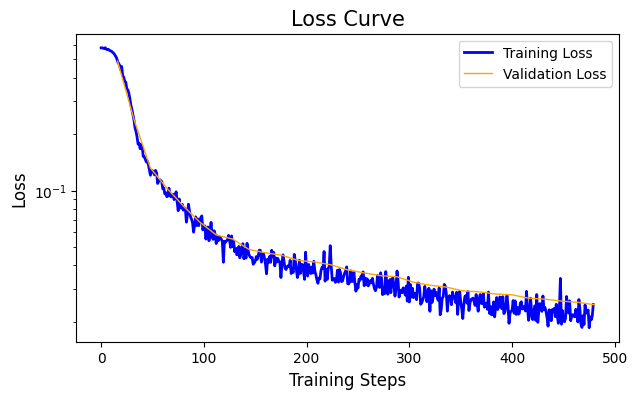

In [25]:
##### loss 그래프 그리기
plt.figure(figsize=(7,4))

plt.plot(range(len(training_loss_list)), training_loss_list, label='Training Loss',lw=2,color='blue')
plt.plot((np.arange(epochs)+1)*16, validation_loss_list, label='Validation Loss',lw=1,color='orange')
plt.semilogy()
plt.title('Loss Curve', fontsize=15)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Training Steps', fontsize=12)
plt.legend()
plt.show()

##### 학습 이후 모델 테스트 성능 평가

In [26]:
###### Relative L2 error on Test set
ntest = 0
model.eval()
rels = []
with torch.no_grad():
  for x,y in test_loader:
    x,y = x.to(device), y.to(device)
    out = model(x).reshape(y.shape)
    out = out*sol_std + sol_mean
    num = torch.linalg.vector_norm(y - out, dim=(1,2,3))
    den = torch.linalg.vector_norm(y, dim=(1,2,3))
    rels.append((num/den).cpu())
    ntest+=1
mean_rel = torch.cat(rels).mean().item()

print("Relative L2 error on Test dataset: %.3e" % (mean_rel))

Relative L2 error on Test dataset: 2.145e-02


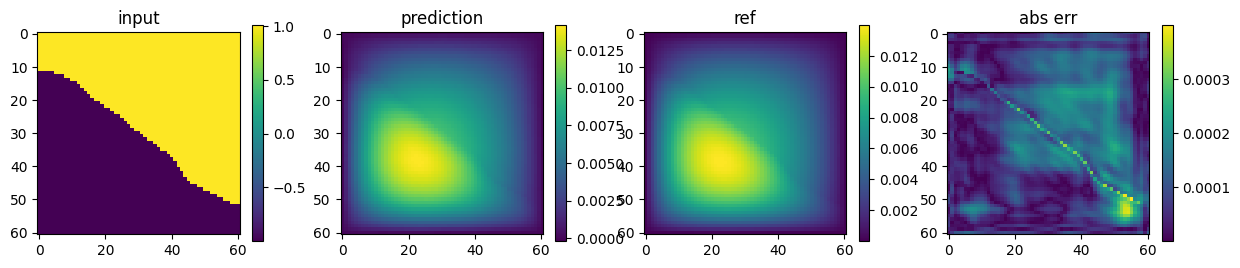

In [27]:
import matplotlib.pyplot as plt

idx = 0
plt.figure(figsize=(15,4))
plt.subplot(1,4,1)
plt.imshow(x[idx,0].cpu().numpy())
plt.colorbar(shrink=0.7)
plt.title("input")
plt.subplot(1,4,2)
plt.imshow(out[idx,0].cpu().numpy())
plt.colorbar(shrink=0.7)
plt.title("prediction")
plt.subplot(1,4,3)
plt.imshow(y[idx,0].cpu().numpy())
plt.colorbar(shrink=0.7)
plt.title("ref")
plt.subplot(1,4,4)
plt.imshow(np.abs(y[idx,0].cpu().numpy() - out[idx,0].cpu().numpy()))
plt.colorbar(shrink=0.7)
plt.title("abs err")
plt.show()